In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
plt.rcParams['font.family'] = 'Noto Sans CJK JP'

from IPython.display import Audio

from module import config_lib, utils_lib

In [2]:
class DatasetConfig:
    def __init__(self, kaggle_notebook=False, debug=False):
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.model_path = '/kaggle/input/birdclef-2025-0330'
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.models_dir = "../models/" # 全modelの保存先
            self.model_path = self.models_dir # 各モデルの保存先．学習時に動的に変更．
            self.RAW_DIR = '../data/raw/'
            self.PROCESSED_DIR = '../data/processed/'
            
            self.spectrogram_npy = '../data/processed/baseline/birdclef2025_melspec_5sec_256_256.npy'
            self.pseudo_label_csv = "../data/processed/pseudo_labels/ensemble_7sec_pseudoth0.5/pseudo_label.csv"
            self.pseudo_melspec_npy = "../data/processed/train_soundscapes_0407/train_soundscapes_melspecs.npy"


        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5.0 # 推論時のウィンドウサイズ
        self.TARGET_DURATION = 5 # データセット作成時のウィンドウサイズ
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 512
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        self.N_MAX = 50 if self.debug else None        
        self.N_JOBS = 16  # 並列処理のスレッド数 16くらいでいい
        self.LOAD_ENGINE = 'torchaudio'  # librosa or torchaudio
        self.SKIP_RESIZE = False  # resizeしないならTrue
        self.seed = 42
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        self.use_tta = False
        self.tta_count = 3
        self.threshold = 0.5

        self.use_specific_folds = False
        self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

        self.debug_count = 3
            

In [3]:
cfg = DatasetConfig()
utils_lib.set_seed(cfg.seed)

In [4]:
train_label = pd.read_csv(cfg.train_csv)
submission = pd.read_csv(cfg.submission_csv)
taxonomy = pd.read_csv(cfg.taxonomy_csv)

In [5]:
train_label.head()

primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  
0  cc-by-nc-sa 4.0  
1  cc-by-nc-sa 4.0  
2  cc-by-nc-sa 4.0  
3  cc-by-nc-sa 4.0  
4  cc-by-nc-sa 4.0

In [6]:
taxonomy.head()

primary_label  inat_taxon_id               scientific_name  \
0       1139490        1139490          Ragoniella pulchella   
1       1192948        1192948         Oxyprora surinamensis   
2       1194042        1194042           Copiphora colombiae   
3        126247         126247       Leptodactylus insularum   
4       1346504        1346504  Neoconocephalus brachypterus   

                    common_name class_name  
0          Ragoniella pulchella    Insecta  
1         Oxyprora surinamensis    Insecta  
2           Copiphora colombiae    Insecta  
3        Spotted Foam-nest Frog   Amphibia  
4  Neoconocephalus brachypterus    Insecta

In [7]:
df = pd.merge(train_label, taxonomy[["primary_label", "inat_taxon_id","class_name"]], on='primary_label', how='left')
df.head()

primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  inat_taxon_id class_name  
0  cc-by-nc-sa 4.0        1139490    Insecta  
1  cc-by-nc-sa 4.0        1139490    Insecta  
2  cc-by-nc-sa 4.0        1192948    Insecta  
3  cc-by-nc-sa 4.0        1192948    Insecta  
4  cc-by-nc-sa 4.0        1192948    Insecta

In [8]:
print("\n欠損値:\n", df.isnull().sum())
print("\nデータ型:\n", df.dtypes)



欠損値:
 primary_label         0
secondary_labels      0
type                  0
filename              0
collection            0
rating                0
url                   0
latitude            809
longitude           809
scientific_name       0
common_name           0
author                0
license               0
inat_taxon_id         0
class_name            0
dtype: int64

データ型:
 primary_label        object
secondary_labels     object
type                 object
filename             object
collection           object
rating              float64
url                  object
latitude            float64
longitude           float64
scientific_name      object
common_name          object
author               object
license              object
inat_taxon_id         int64
class_name           object
dtype: object


In [9]:

# --- primary_label の分布 ---
print("\nprimary_label のユニーク数:", df['primary_label'].nunique())
print("\nprimary_label 上位10件:\n", df['primary_label'].value_counts().head(10))




primary_label のユニーク数: 206

primary_label 上位10件:
 primary_label
grekis     990
compau     808
trokin     787
roahaw     709
banana     610
whtdov     572
socfly1    543
yeofly1    525
bobfly1    514
wbwwre1    499
Name: count, dtype: int64


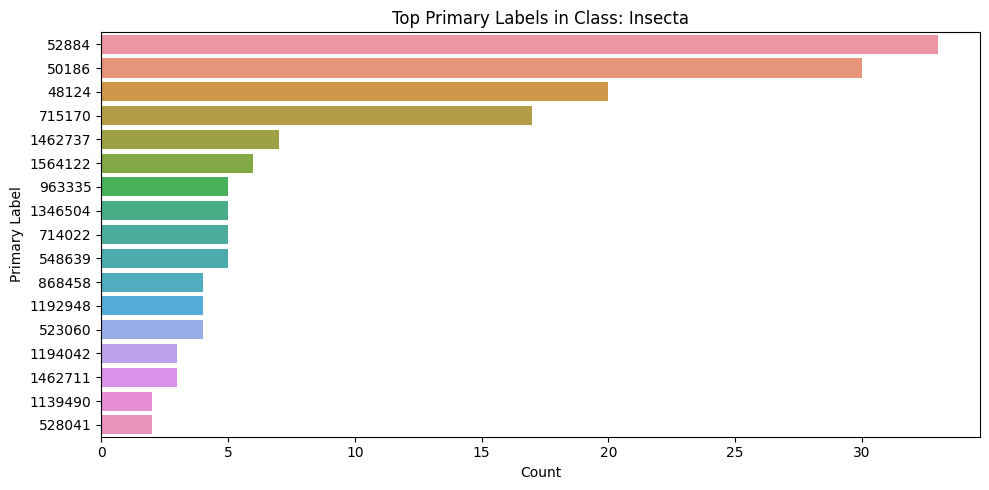

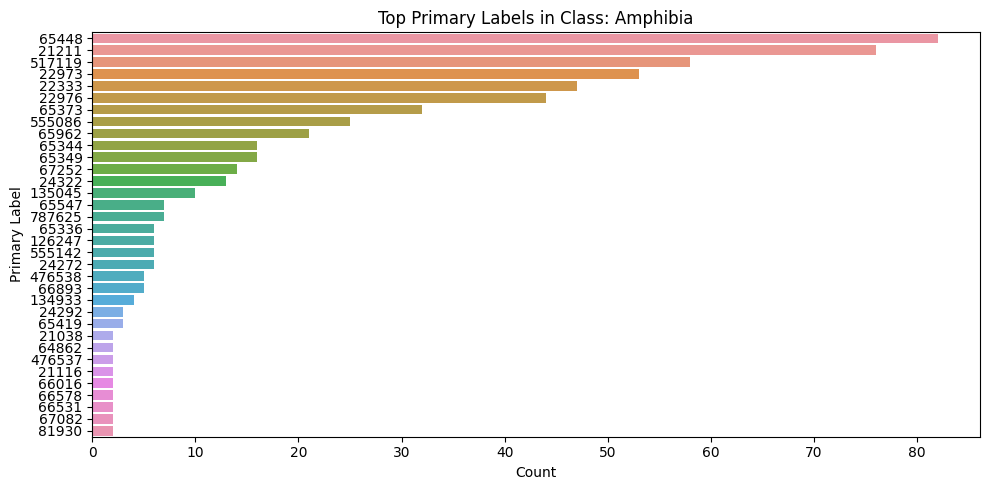

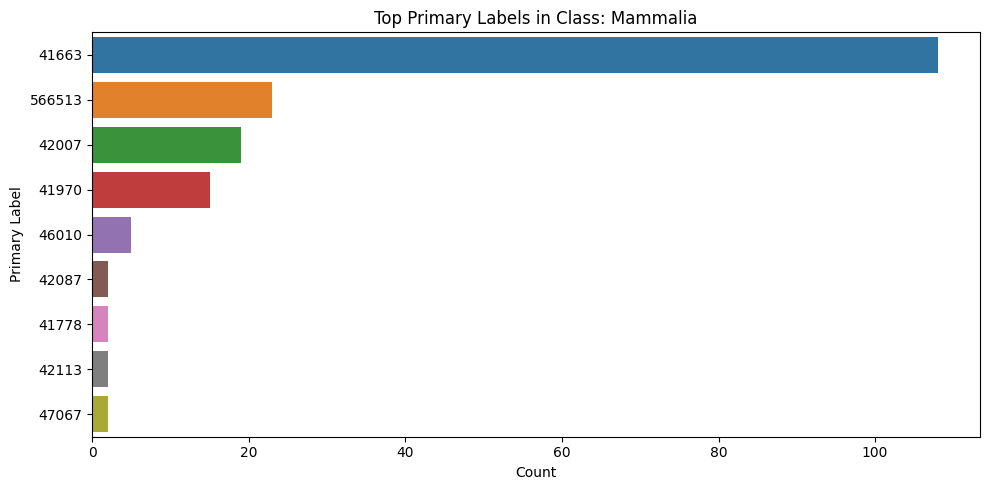

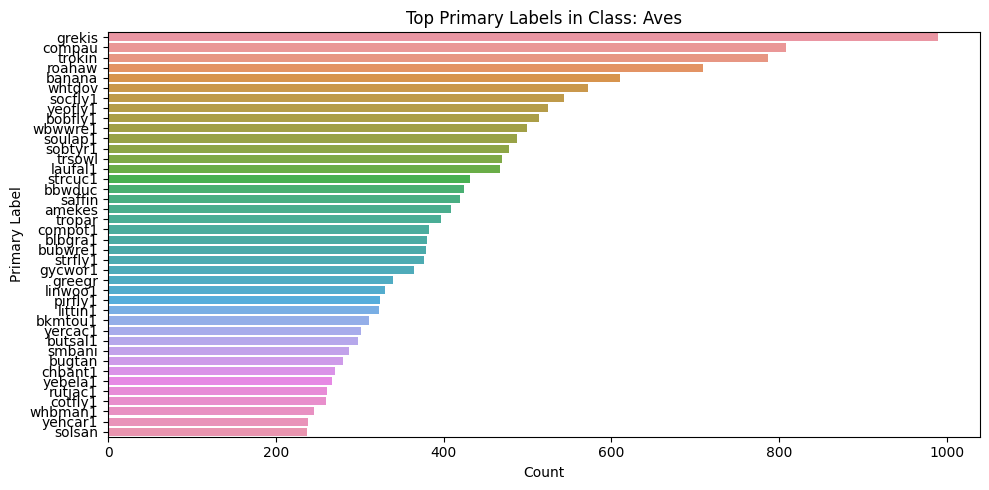

In [10]:
df[df["class_name"] == "Aves"].value_counts("primary_label").head(10)

# class_name ごとに primary_label の出現数トップ10を抽出
top_labels_per_class = {}
for class_name in df['class_name'].unique():
    top_labels = df[df["class_name"] == class_name].value_counts("primary_label").head(40)
    top_labels_per_class[class_name] = top_labels

# 棒グラフで可視化（クラスごとに別のグラフ）
for class_name, label_counts in top_labels_per_class.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.values, y=label_counts.index)
    plt.title(f'Top Primary Labels in Class: {class_name}')
    plt.xlabel('Count')
    plt.ylabel('Primary Label')
    plt.tight_layout()
    plt.show()

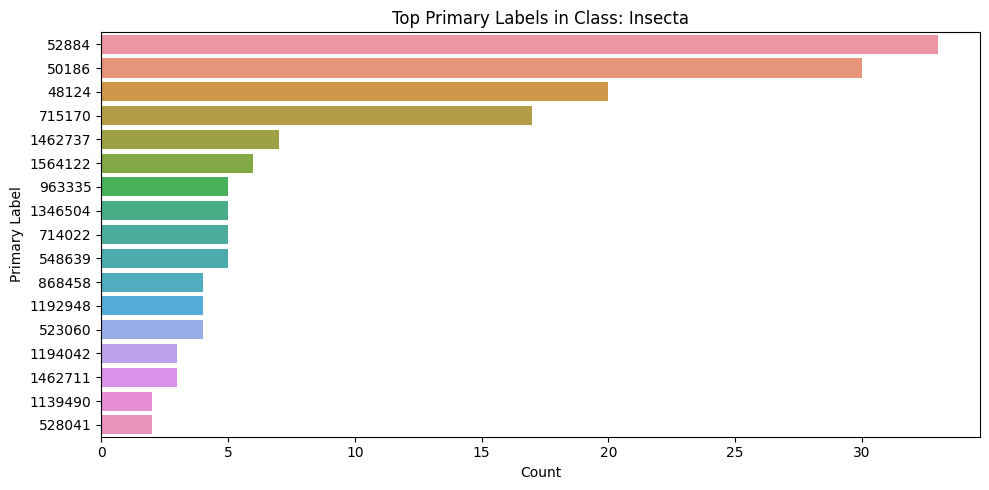

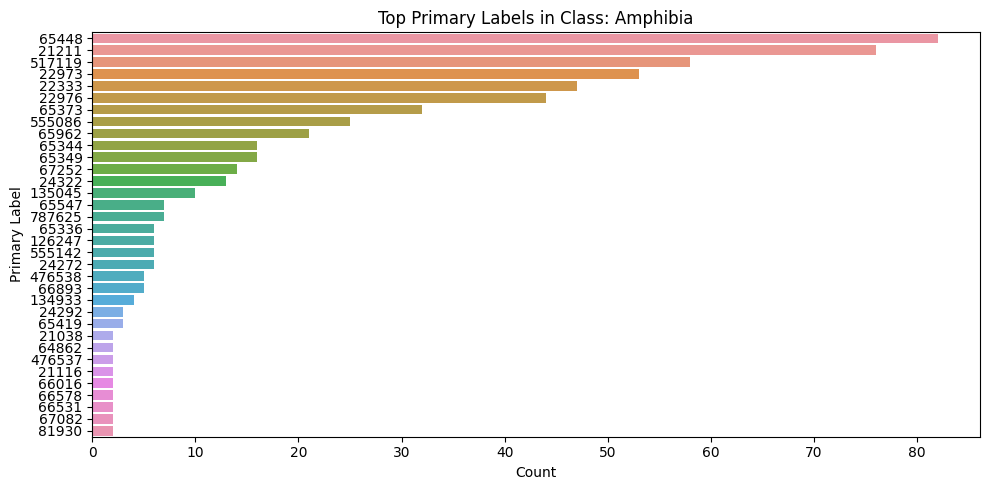

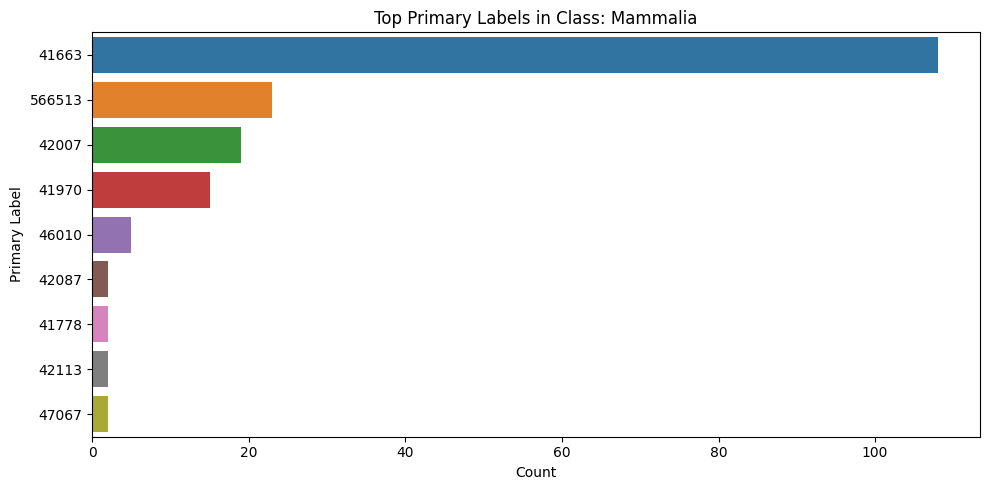

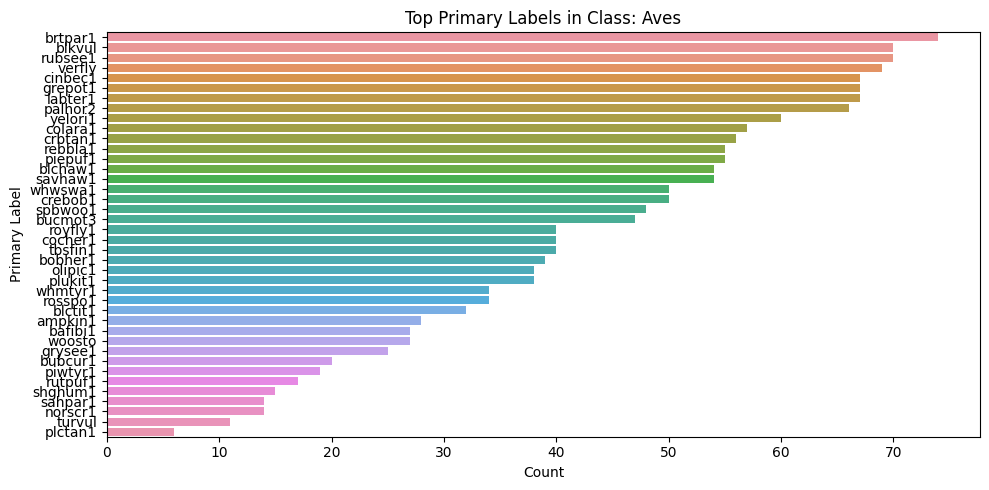

In [11]:

# 出現数ボトム40
top_labels_per_class = {}
for class_name in df['class_name'].unique():
    top_labels = df[df["class_name"] == class_name].value_counts("primary_label").tail(40)
    top_labels_per_class[class_name] = top_labels

# 棒グラフで可視化（クラスごとに別のグラフ）
for class_name, label_counts in top_labels_per_class.items():
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_counts.values, y=label_counts.index)
    plt.title(f'Top Primary Labels in Class: {class_name}')
    plt.xlabel('Count')
    plt.ylabel('Primary Label')
    plt.tight_layout()
    plt.show()


class_name ごとの primary_label のユニーク数:
   class_name  primary_label
1       Aves            146
0   Amphibia             34
2    Insecta             17
3   Mammalia              9


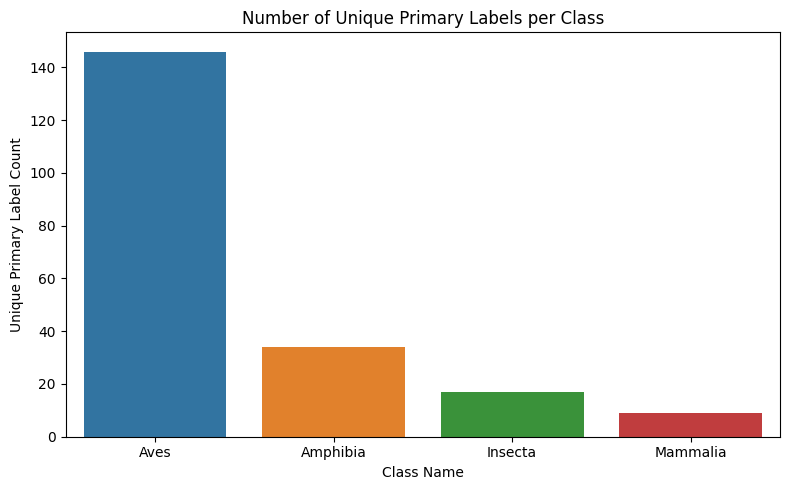

In [12]:
# 生物種ごとのラベル数
# class_name ごとの primary_label のユニーク数をカウント
label_counts = df.groupby('class_name')['primary_label'].nunique().reset_index()
label_counts = label_counts.sort_values('primary_label', ascending=False)

print("\nclass_name ごとの primary_label のユニーク数:\n", label_counts)

plt.figure(figsize=(8, 5))
sns.barplot(data=label_counts, x='class_name', y='primary_label')
plt.title('Number of Unique Primary Labels per Class')
plt.xlabel('Class Name')
plt.ylabel('Unique Primary Label Count')
plt.tight_layout()
plt.show()


class_name の分布:
 class_name
Aves        27648
Amphibia      583
Mammalia      178
Insecta       155
Name: count, dtype: int64


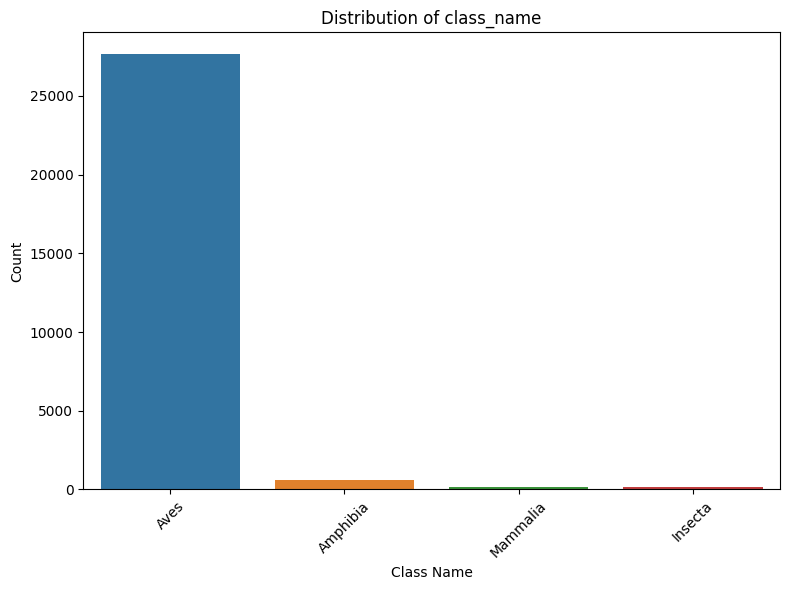

In [13]:
# --- class_name の分布 ---
print("\nclass_name の分布:\n", df['class_name'].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='class_name', order=df['class_name'].value_counts().index)
plt.title('Distribution of class_name')
plt.xlabel('Class Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


rating の分布:
 rating
0.0    7948
0.5      26
1.0     228
1.5      70
2.0     752
2.5     360
3.0    2886
3.5     895
4.0    7582
4.5    1261
5.0    6556
Name: count, dtype: int64


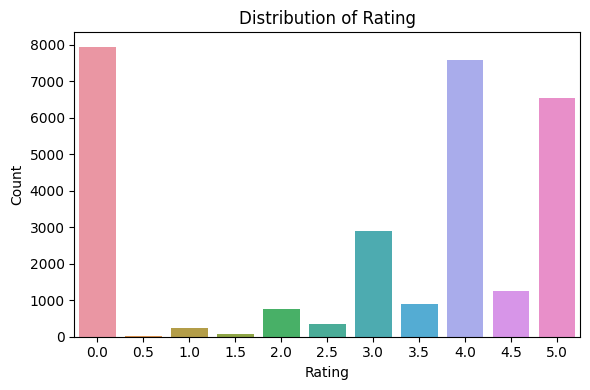

In [14]:

# --- rating の分布 ---
print("\nrating の分布:\n", df['rating'].value_counts().sort_index())


plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='rating', order=sorted(df['rating'].unique()))
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

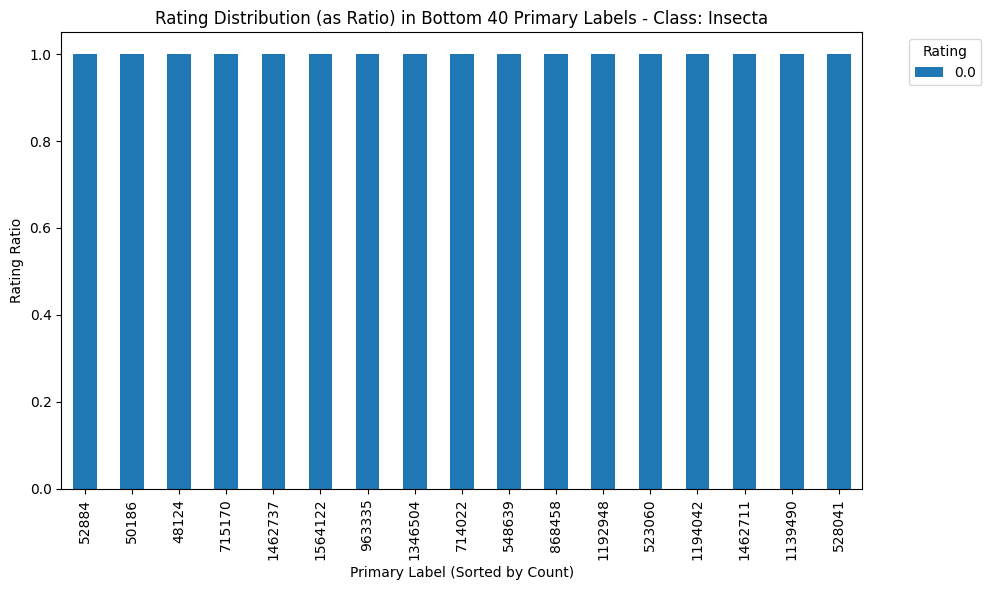

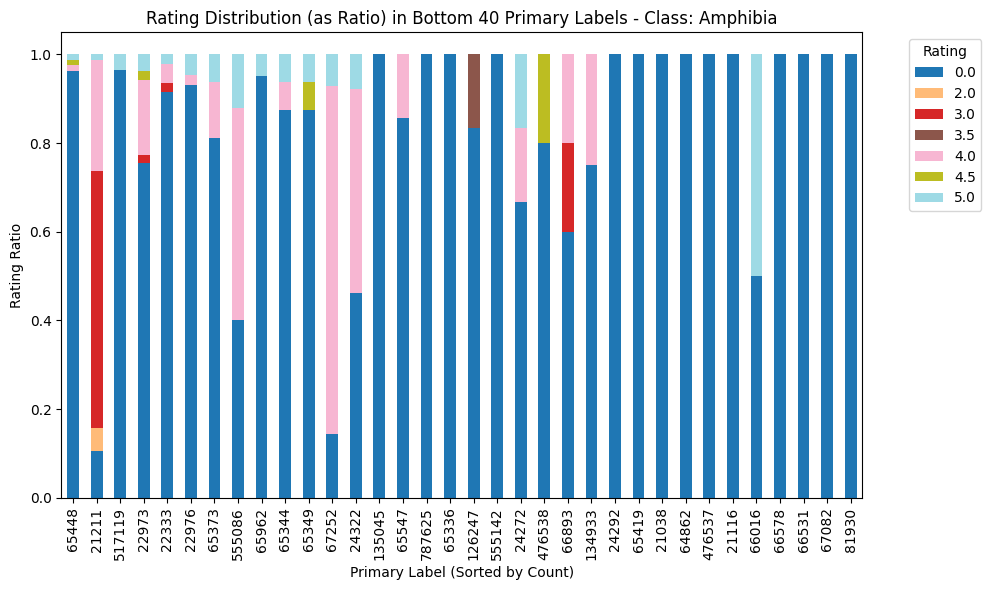

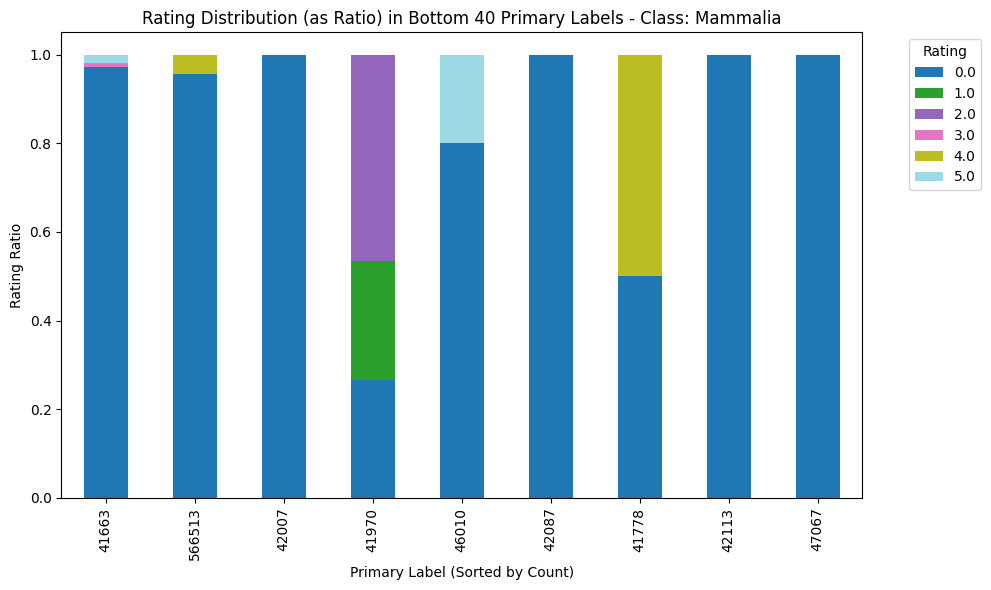

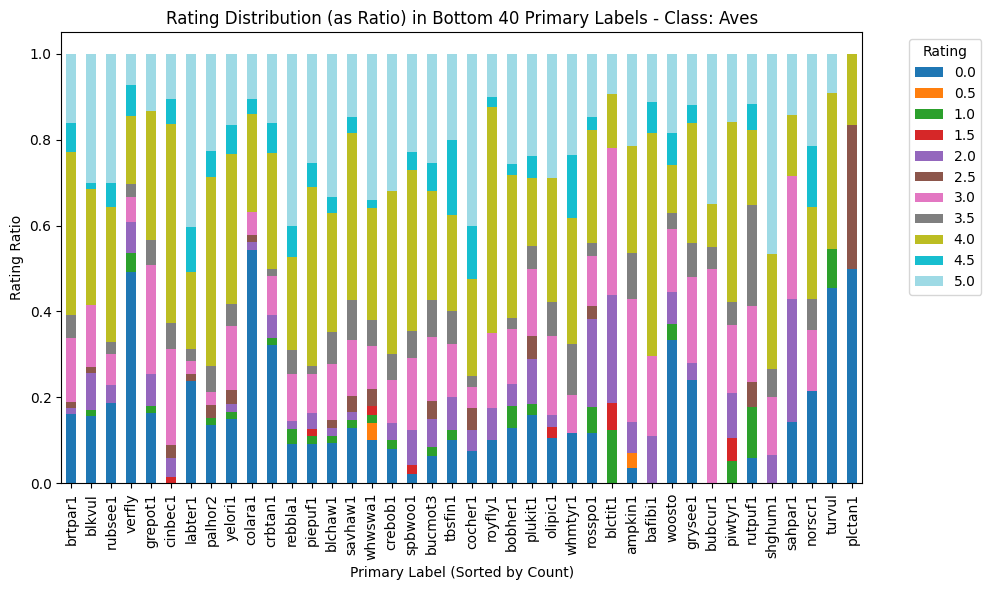

In [15]:
for class_name in df['class_name'].unique():
    # ボトム40の primary_label を抽出
    label_counts = df[df["class_name"] == class_name].value_counts("primary_label").tail(40)
    bottom_labels = label_counts.index.tolist()

    # ボトム40に該当する行だけ抽出
    subset = df[(df["class_name"] == class_name) & (df["primary_label"].isin(bottom_labels))]

    # primary_label × rating のクロス集計（件数）
    pivot = pd.crosstab(subset['primary_label'], subset['rating'])

    # ❗primary_label の出現数で降順にソート
    pivot['total_count'] = pivot.sum(axis=1)
    pivot = pivot.sort_values('total_count', ascending=False)
    pivot = pivot.drop(columns='total_count')  # 可視化には不要

    # 割合に変換
    pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)

    # 積み上げ棒グラフ
    pivot_pct.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='tab20')
    plt.title(f'Rating Distribution (as Ratio) in Bottom 40 Primary Labels - Class: {class_name}')
    plt.xlabel('Primary Label (Sorted by Count)')
    plt.ylabel('Rating Ratio')
    plt.xticks(rotation=90)
    plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

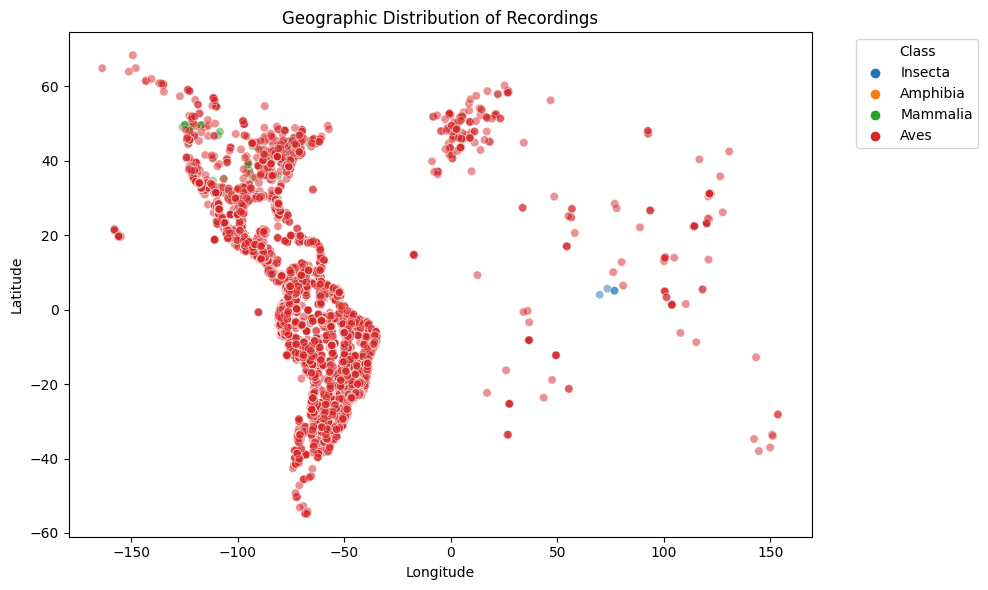

In [16]:
# --- 地理的分布の可視化 ---
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='longitude', y='latitude', hue='class_name', alpha=0.5)
plt.title('Geographic Distribution of Recordings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [17]:


def play_audio(filename, base_path):
    """
    音声ファイルを再生する。
    
    Parameters:
    - filename: メタデータに含まれるファイルパス（例: '1139490/CSA36385.ogg'）
    - base_path: self.train_datadir に相当するルートパス
    """
    filepath = os.path.join(base_path, filename)
    if os.path.exists(filepath):
        return Audio(filename=filepath)
    else:
        print("ファイルが見つかりません:", filepath)
        



In [18]:
# Insectaは最初に鳴いてる？その後人による解説

In [19]:
play_audio("rebbla1/XC560068.ogg", cfg.train_datadir)

In [20]:
df[df["class_name"] == "Insecta"].head()

primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  inat_taxon_id class_name  
0  cc-by-nc-sa 4.0        1139490    Insecta  
1  cc-by-nc-sa 4.0        1139490    Insecta  
2  cc-by-nc-sa 4.0        1192948    Insecta  
3  cc-by-nc-sa 4.0        1192948    Insecta  
4  cc-by-nc-sa 4.0        1192948    Insecta

In [21]:
import librosa
def inverse_melspec(mel_spec_norm, config):
    """
    正規化された Mel スペクトログラム（0〜1）を元の波形に近づけて再生。
    
    Parameters:
    - mel_spec_norm: 正規化済みメルスペクトログラム（float32, shape: (128, T)）
    - config: 設定オブジェクト（DatasetConfig）

    Returns:
    - IPython.display.Audio オブジェクト
    """

    # ① 0〜1 の正規化を元に戻す
    mel_spec_db = mel_spec_norm * (0 - (-80)) + (-80)  # librosa.power_to_db の typical range: [-80, 0]

    # ② dB → power
    mel_power = librosa.db_to_power(mel_spec_db)

    # ③ mel → STFT
    stft = librosa.feature.inverse.mel_to_stft(
    M=mel_power,
    sr=config.FS,
    n_fft=config.N_FFT,
    power=2.0,
    fmin=config.FMIN,
    fmax=config.FMAX
    )

    # ④ Griffin-Lim で波形復元
    waveform = librosa.griffinlim(
        stft,
        n_iter=32,
        hop_length=config.HOP_LENGTH,
        win_length=config.N_FFT
    )

    return Audio(waveform, rate=config.FS)

In [22]:
spec = np.load("../data/processed/mel_mixup/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
working_df = pd.read_csv("../data/processed/mel_mixup/train.csv")
working_df[working_df["primary_label"] == "woosto"].tail()

primary_label secondary_labels  type               filename collection  \
31908        woosto      ['blbgra1']  ['']  woosto/iNat640627.ogg       iNat   
31909        woosto      ['soulap1']  ['']  woosto/iNat683978.ogg       iNat   
31910        woosto       ['bugtan']  ['']  woosto/iNat684005.ogg       iNat   
31911        woosto      ['littin1']  ['']  woosto/iNat684010.ogg       iNat   
31912        woosto      ['socfly1']  ['']  woosto/iNat859775.ogg       iNat   

       rating                                               url  latitude  \
31908     0.0  https://static.inaturalist.org/sounds/640627.m4a   26.4782   
31909     0.0  https://static.inaturalist.org/sounds/683978.m4a   28.5736   
31910     0.0  https://static.inaturalist.org/sounds/684005.m4a   28.5736   
31911     0.0  https://static.inaturalist.org/sounds/684010.wav   28.5731   
31912     0.0  https://static.inaturalist.org/sounds/859775.m4a   -3.0937   

       longitude     scientific_name  ...               samplename class  \
31908   -80.1436  Mycteria americana  ...  woosto-iNat640627_crop0  Aves   
31909   -80.9910  Mycteria americana  ...  woosto-iNat683978_crop0  Aves   
31910   -80.9910  Mycteria americana  ...  woosto-iNat684005_crop0  Aves   
31911   -80.9907  Mycteria americana  ...  woosto-iNat684010_crop0  Aves   
31912   -79.8490  Mycteria americana  ...  woosto-iNat859775_crop0  Aves   

      crop_strategy  n_augment multi_crop           group_id fold is_mixup  \
31908        center          1       True  woosto-iNat640627    1     True   
31909        center          1       True  woosto-iNat683978    2     True   
31910        center          1       True  woosto-iNat684005    0     True   
31911        center          1       True  woosto-iNat684010    1     True   
31912        center          1       True  woosto-iNat859775    2     True   

              mix_partner  mixup_weight  
31908    blbgra1-XC243284        0.7948  
31909  soulap1-iNat607045        0.8433  
31910     bugtan-XC446774        0.7542  
31911    littin1-XC935058        0.7405  
31912     socfly1-XC82282        0.7628  

[5 rows x 25 columns]

In [23]:
mel = spec["woosto-iNat683978"]
utils_lib.inverse_melspec(mel, cfg)

/opt/conda/lib/python3.10/site-packages/librosa/feature/inverse.py:99: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(


In [24]:
mel = spec["woosto-iNat683978_crop0"]
utils_lib.inverse_melspec(mel, cfg)

In [25]:
mel = spec["soulap1-iNat607045"]
utils_lib.inverse_melspec(mel, cfg)

In [26]:
play_audio("1139490/CSA36389.ogg", cfg.train_datadir)

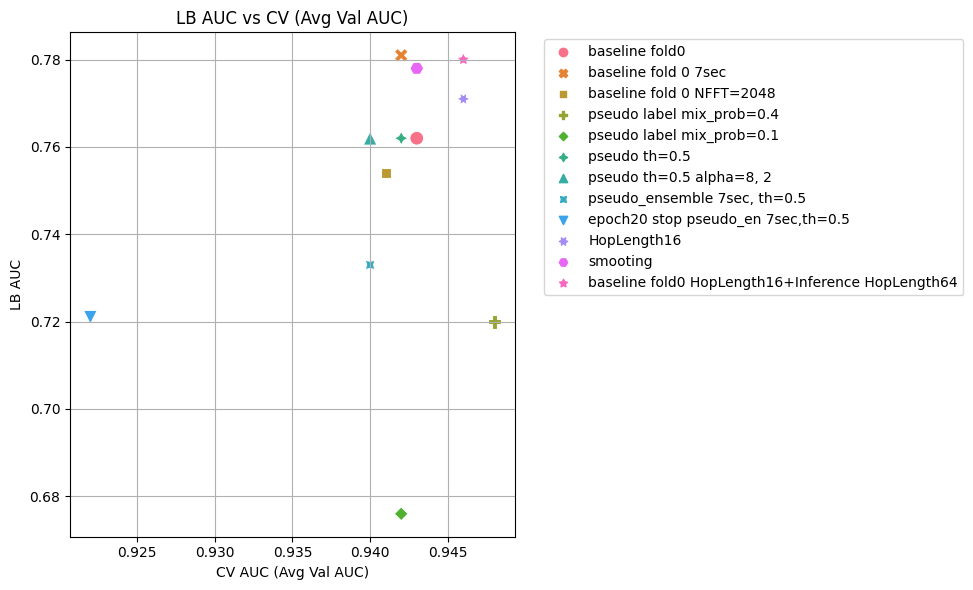

In [27]:
# LBとCVの比較
data = [
    {"Note": "baseline fold0", "LB AUC": 0.762, "Avg Val Auc": 0.943},
    {"Note": "baseline fold 0 7sec", "LB AUC": 0.781, "Avg Val Auc": 0.942},
    {"Note": "baseline fold 0 NFFT=2048", "LB AUC": 0.754, "Avg Val Auc": 0.941},
    {"Note": "baseline fold 0 NFFT=2048, epoch=20", "LB AUC": None, "Avg Val Auc": 0.942},
    {"Note": "pseudo label mix_prob=0.4", "LB AUC": 0.720, "Avg Val Auc": 0.948},
    {"Note": "pseudo label mix_prob=0.1", "LB AUC": 0.676, "Avg Val Auc": 0.942},
    {"Note": "pseudo th=0.5", "LB AUC": 0.762, "Avg Val Auc": 0.942},
    {"Note": "pseudo th=0.5 alpha=8, 2", "LB AUC": 0.762, "Avg Val Auc": 0.940},
    {"Note": "pseudo_ensemble 7sec, th=0.5", "LB AUC": 0.733, "Avg Val Auc": 0.940},
    {"Note": "epoch20 stop pseudo_en 7sec,th=0.5", "LB AUC": 0.721, "Avg Val Auc": 0.922},
    {"Note": "baseline batch128", "LB AUC": None, "Avg Val Auc": 0.923},
    {"Note": "baseline batch128 epoch20", "LB AUC": None, "Avg Val Auc": 0.935},
    {"Note": "HopLength16", "LB AUC": 0.771, "Avg Val Auc": 0.946},
    {"Note": "smooting", "LB AUC": 0.778, "Avg Val Auc": 0.943},
    {"Note": "FabioHead", "LB AUC": None, "Avg Val Auc": 0.945},
    {"Note": "baseline fold0 HopLength16+Inference HopLength64", "LB AUC": 0.780, "Avg Val Auc": 0.946}
]

# DataFrameの作成とプロット
auc_df = pd.DataFrame(data)
auc_df_plot = auc_df.dropna()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=auc_df_plot, x="Avg Val Auc", y="LB AUC", hue="Note", style="Note", s=100)
plt.title("LB AUC vs CV (Avg Val AUC)")
plt.xlabel("CV AUC (Avg Val AUC)")
plt.ylabel("LB AUC")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
train = pd.merge(train_label, taxonomy[["primary_label", "inat_taxon_id","class_name"]], on='primary_label', how='left')
train.head()

primary_label secondary_labels  type              filename collection  \
0       1139490             ['']  ['']  1139490/CSA36385.ogg        CSA   
1       1139490             ['']  ['']  1139490/CSA36389.ogg        CSA   
2       1192948             ['']  ['']  1192948/CSA36358.ogg        CSA   
3       1192948             ['']  ['']  1192948/CSA36366.ogg        CSA   
4       1192948             ['']  ['']  1192948/CSA36373.ogg        CSA   

   rating                                                url  latitude  \
0     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
1     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   
2     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   
3     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.2800   
4     0.0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3791   

   longitude        scientific_name            common_name             author  \
0   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
1   -73.7128   Ragoniella pulchella   Ragoniella pulchella  Fabio A. Sarria-S   
2   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
3   -73.8582  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   
4   -73.7313  Oxyprora surinamensis  Oxyprora surinamensis  Fabio A. Sarria-S   

           license  inat_taxon_id class_name  
0  cc-by-nc-sa 4.0        1139490    Insecta  
1  cc-by-nc-sa 4.0        1139490    Insecta  
2  cc-by-nc-sa 4.0        1192948    Insecta  
3  cc-by-nc-sa 4.0        1192948    Insecta  
4  cc-by-nc-sa 4.0        1192948    Insecta

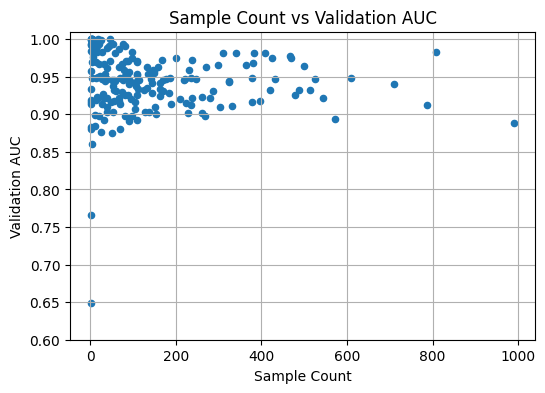

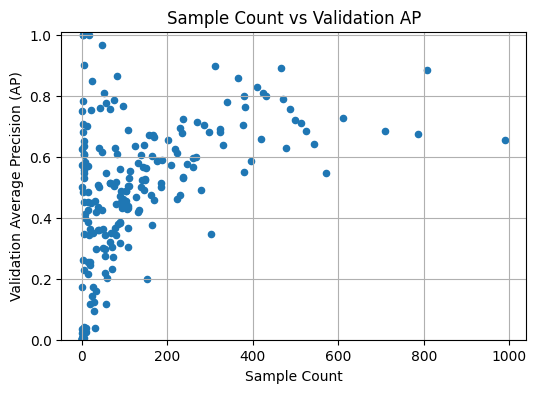

In [29]:
# サンプル数と性能の関係．mel_0411のfスコア
from glob import glob

# モデルスコアの保存場所
model_path = "../models/mel_0411/"

# 全 fold のスコアファイルを取得
score_files = sorted(glob(os.path.join(model_path, "best_val_classwise_score_fold*.csv")))

# すべてのスコアを格納するリスト
all_scores = []

# 各 fold のスコアを読み込んでリストに追加
for file in score_files:
    df = pd.read_csv(file)
    all_scores.append(df)

# 全スコアを一つのDataFrameに統合
combined_df = pd.concat(all_scores)

# ラベルごとに平均を計算
mean_scores = combined_df.groupby("label").agg({
    "val_auc": "mean",
    "val_ap": "mean"
}).reset_index()


label_counts = train["primary_label"].value_counts().rename_axis("label").reset_index(name="sample_count")
# mean_scores（fold平均済み）とマージ
score_sample_df = mean_scores.merge(label_counts, on="label", how="left")

df = score_sample_df.copy()
# val_auc vs sample_count
plt.figure(figsize=(6, 4))
plt.scatter(df["sample_count"], df["val_auc"], s=20, )
plt.xlabel("Sample Count")
plt.ylabel("Validation AUC")
plt.title("Sample Count vs Validation AUC")
plt.grid(True)
plt.ylim(0.6, 1.01)
plt.show()


# val_ap vs sample_count
plt.figure(figsize=(6, 4))
plt.scatter(df["sample_count"], df["val_ap"], s=20)
plt.xlabel("Sample Count")
plt.ylabel("Validation Average Precision (AP)")
plt.title("Sample Count vs Validation AP")
plt.grid(True)
plt.ylim(0, 1.01)
plt.show()

# baselineよりもサンプル数が少ない部分の性能改善が見られる．

In [30]:
score_sample_df

label   val_auc    val_ap  sample_count
0    1139490  0.993522  0.173516             2
1    1192948  1.000000  1.000000             4
2    1194042  0.969421  0.013184             3
3     126247  0.999387  0.546753             6
4    1346504  0.993276  0.634397             5
..       ...       ...       ...           ...
201  yehcar1  0.921359  0.530371           238
202  yelori1  0.931590  0.203646            60
203  yeofly1  0.946588  0.685877           525
204  yercac1  0.909216  0.346247           302
205   ywcpar  0.947680  0.524209           142

[206 rows x 4 columns]

In [31]:
score_sample_df

label   val_auc    val_ap  sample_count
0    1139490  0.993522  0.173516             2
1    1192948  1.000000  1.000000             4
2    1194042  0.969421  0.013184             3
3     126247  0.999387  0.546753             6
4    1346504  0.993276  0.634397             5
..       ...       ...       ...           ...
201  yehcar1  0.921359  0.530371           238
202  yelori1  0.931590  0.203646            60
203  yeofly1  0.946588  0.685877           525
204  yercac1  0.909216  0.346247           302
205   ywcpar  0.947680  0.524209           142

[206 rows x 4 columns]

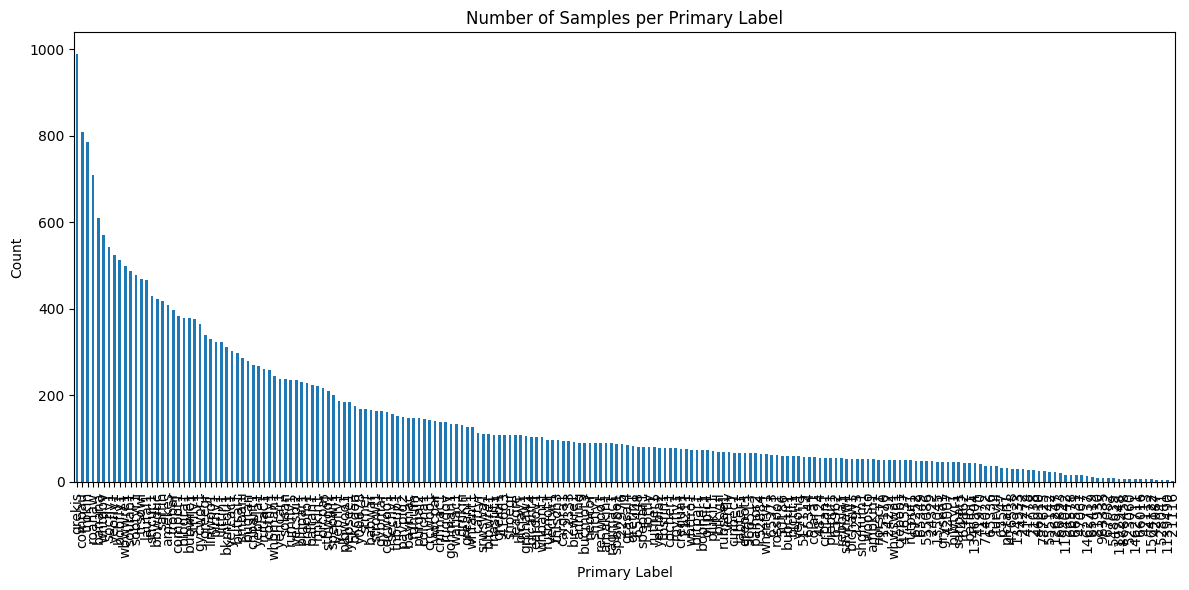

In [32]:
train_aug = pd.read_csv("../data/processed/mel_CropAug50_0413/train.csv")


df = train_aug
import pandas as pd
import matplotlib.pyplot as plt

# 例: DataFrame を読み込む場合（既にdfがあるならこの行は不要）
# df = pd.read_csv("your_file.csv")

# primary_labelごとの件数をカウント
label_counts = df['primary_label'].value_counts()

# 棒グラフの描画
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Number of Samples per Primary Label')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

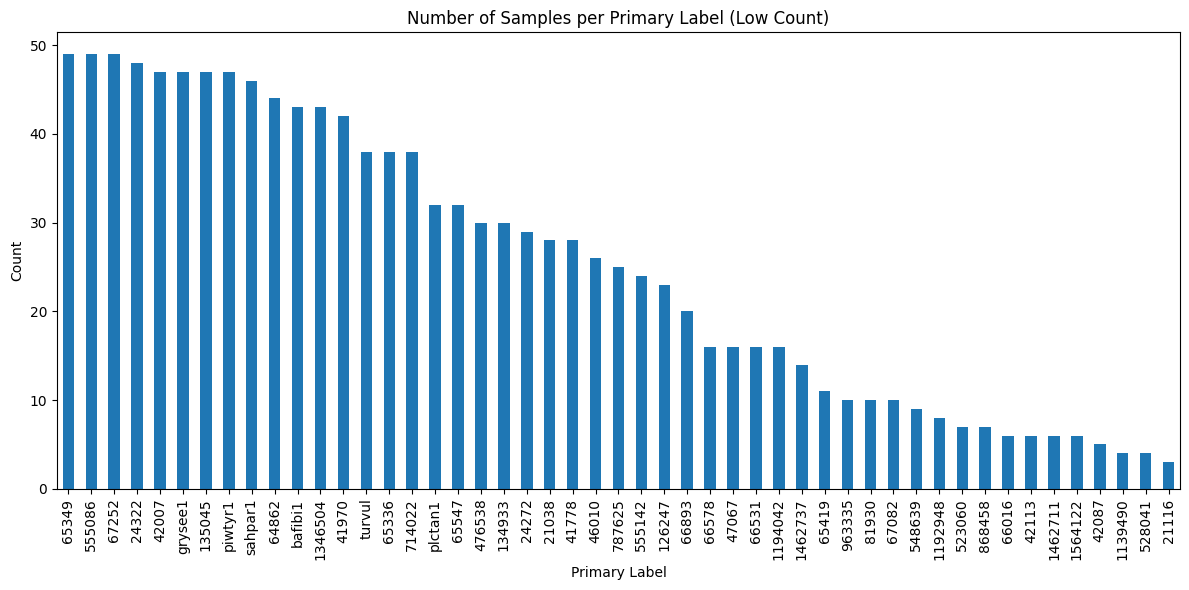

['1139490' '1192948' '1194042' '126247' '1346504' '134933' '135045'
 '1462711' '1462737' '1564122' '21038' '21116' '24272' '24322' '41778'
 '41970' '42007' '42087' '42113' '46010' '47067' '476538' '523060'
 '528041' '548639' '555086' '555142' '64862' '65336' '65349' '65419'
 '65547' '66016' '66531' '66578' '66893' '67082' '67252' '714022' '787625'
 '81930' '868458' '963335' 'bafibi1' 'grysee1' 'piwtyr1' 'plctan1'
 'sahpar1' 'turvul'] 49


In [33]:
# label countsが50未満のものを抽出
label_counts = df['primary_label'].value_counts()
low_count_labels = label_counts[label_counts < 50].index.tolist()
low_count_df = df[df['primary_label'].isin(low_count_labels)]
low_count_df = low_count_df.sort_values(by='primary_label')
low_count_df = low_count_df.reset_index(drop=True)
# primary_labelごとの件数をカウント
label_counts = low_count_df['primary_label'].value_counts()
# 棒グラフの描画
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Number of Samples per Primary Label (Low Count)')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(low_count_df["primary_label"].unique(), len(low_count_df["primary_label"].unique()))

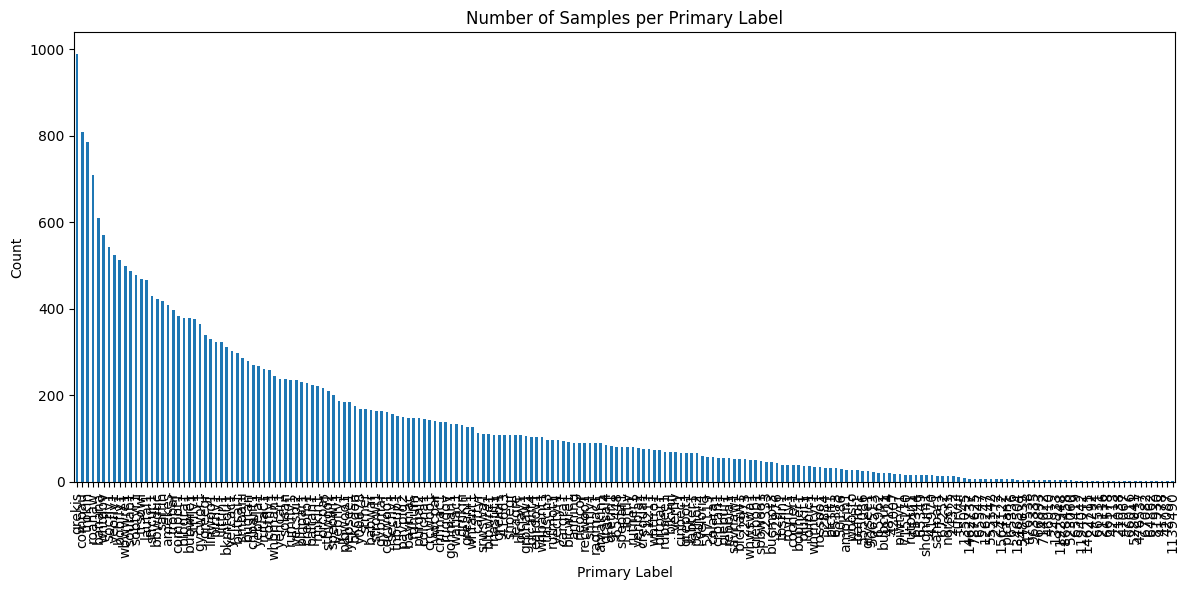

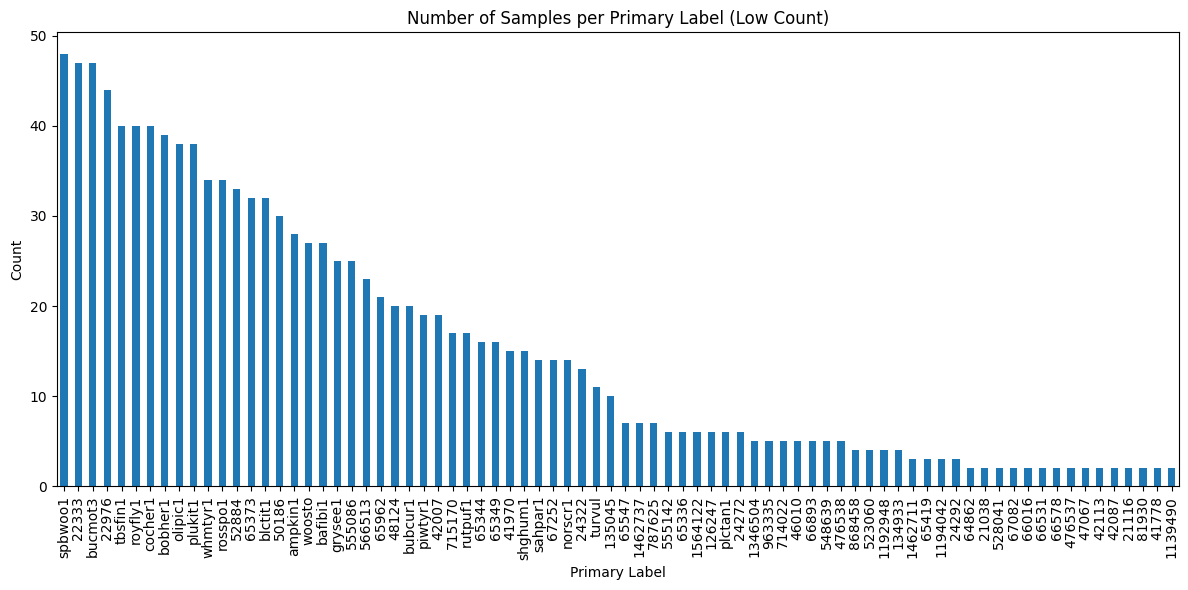

['1139490' '1192948' '1194042' '126247' '1346504' '134933' '135045'
 '1462711' '1462737' '1564122' '21038' '21116' '22333' '22976' '24272'
 '24292' '24322' '41778' '41970' '42007' '42087' '42113' '46010' '47067'
 '476537' '476538' '48124' '50186' '523060' '528041' '52884' '548639'
 '555086' '555142' '566513' '64862' '65336' '65344' '65349' '65373'
 '65419' '65547' '65962' '66016' '66531' '66578' '66893' '67082' '67252'
 '714022' '715170' '787625' '81930' '868458' '963335' 'ampkin1' 'bafibi1'
 'blctit1' 'bobher1' 'bubcur1' 'bucmot3' 'cocher1' 'grysee1' 'norscr1'
 'olipic1' 'piwtyr1' 'plctan1' 'plukit1' 'rosspo1' 'royfly1' 'rutpuf1'
 'sahpar1' 'shghum1' 'spbwoo1' 'tbsfin1' 'turvul' 'whmtyr1' 'woosto'] 78


In [34]:
import pandas as pd
import matplotlib.pyplot as plt

df = train

# 例: DataFrame を読み込む場合（既にdfがあるならこの行は不要）
# df = pd.read_csv("your_file.csv")

# primary_labelごとの件数をカウント
label_counts = df['primary_label'].value_counts()

# 棒グラフの描画
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Number of Samples per Primary Label')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# label countsが50未満のものを抽出
label_counts = df['primary_label'].value_counts()
low_count_labels = label_counts[label_counts < 50].index.tolist()
low_count_df = df[df['primary_label'].isin(low_count_labels)]
low_count_df = low_count_df.sort_values(by='primary_label')
low_count_df = low_count_df.reset_index(drop=True)
# primary_labelごとの件数をカウント
label_counts = low_count_df['primary_label'].value_counts()
# 棒グラフの描画
plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Number of Samples per Primary Label (Low Count)')
plt.xlabel('Primary Label')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print(low_count_df["primary_label"].unique(), len(low_count_df["primary_label"].unique()))

In [ ]:
!pip install pytorch-gradcam
from copy import deepcopy
class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            self.model_path = "/kaggle/input/bc25-models-fold0-mel-0411"
            
            self.device = "cpu"
            self.batch_size = 8
            self.n_jobs = 3
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes/'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.spectrogram_npy = '../data/processed/mel-spec_0329/birdclef2025_melspec_5sec_256_256.npy'
            self.MODELS_DIR = "../models/"
            self.model_path =  "../models/mel_cleaned0413/"
            
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.batch_size = 32
            self.n_jobs = 3

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5
        self.TARGET_DURATION = 5
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = 64
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        
        self.seed = 42
        


        # ===== Inference Mode =====
        if mode == "inference":
            self.use_tta = False
            self.tta_count = 3
            self.threshold = 0.5

            self.use_specific_folds = False
            self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

            self.debug_count = 3
            
            
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 2
            self.selected_folds = [0]
            
    
            
cfg = CFG(mode="inference", kaggle_notebook=False, debug=False)

from module import models_lib

models = models_lib.load_models(cfg, 206)
model = models[0]

Found a total of 5 model files.
Loading model: ../models/mel_cleaned0413/model_fold0.pth
Loading model: ../models/mel_cleaned0413/model_fold1.pth
Loading model: ../models/mel_cleaned0413/model_fold2.pth
Loading model: ../models/mel_cleaned0413/model_fold3.pth
Loading model: ../models/mel_cleaned0413/model_fold4.pth


In [90]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from gradcam import GradCAM
from gradcam.utils import visualize_cam
from torchvision import transforms

# === 1. Melスペクトログラム画像をTensorに変換 ===
def prepare_input_from_melspec(mel_numpy):
    mel_norm = (mel_numpy - mel_numpy.min()) / (mel_numpy.max() - mel_numpy.min() + 1e-6)
    mel_tensor = torch.tensor(mel_norm).unsqueeze(0).unsqueeze(0).float()  # shape: (1, 1, H, W)
    return mel_tensor

# === Conv2dモジュール（オブジェクト）を返すバージョン ===
def get_last_conv_layer(model):
    for module in reversed(list(model.modules())):
        if isinstance(module, torch.nn.Conv2d):
            return module
    raise ValueError("Conv2d 層が見つかりません")



def show_gradcam(model, mel_numpy, target_class, title="Grad-CAM"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval().to(device)

    input_tensor = prepare_input_from_melspec(mel_numpy).to(device)

    target_layer = get_last_conv_layer(model)

    cam = GradCAM(model, target_layer)
    mask, _ = cam(input_tensor, target_class)

    # 可視化
    heatmap, result = visualize_cam(mask, input_tensor[0])
    heatmap = np.transpose(heatmap, (1, 2, 0))  # (H, W, C)
    result = np.transpose(result, (1, 2, 0))

    # === 上下を正しく表示するために上下反転 ===
    heatmap = np.flipud(heatmap)
    result = np.flipud(result)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(heatmap)
    plt.title("CAM Heatmap")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title(title)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [73]:
spec = np.load("../data/processed/mel_cleaned_0413/birdclef2025_melspec_5sec_256_256.npy", allow_pickle=True).item()
working_df = pd.read_csv("../data/processed/mel_cleaned_0413/train.csv")

In [74]:
df = working_df[(working_df["rating"] == 5.0) & (working_df["duration_sec"] < 10)]
df.head()

primary_label secondary_labels                    type  \
231         22976             ['']  ['advertisement call']   
297         41663             ['']                ['call']   
508        517119             ['']  ['advertisement call']   
709         65373             ['']  ['advertisement call']   
921       amakin1             ['']                ['song']   

                 filename collection  rating                            url  \
231    22976/XC893972.ogg         XC     5.0  https://xeno-canto.org/893972   
297    41663/XC697007.ogg         XC     5.0  https://xeno-canto.org/697007   
508   517119/XC893992.ogg         XC     5.0  https://xeno-canto.org/893992   
709    65373/XC941284.ogg         XC     5.0  https://xeno-canto.org/941284   
921  amakin1/XC128804.ogg         XC     5.0  https://xeno-canto.org/128804   

     latitude  longitude              scientific_name  ...        samplename  \
231   20.4215   -88.4714       Leptodactylus fragilis  ...    22976-XC893972   
297   49.1523     2.3752                Procyon lotor  ...    41663-XC697007   
508   10.9747   -84.7441          Rhinella horribilis  ...   517119-XC893992   
709    9.0443   -79.3026  Dendropsophus microcephalus  ...    65373-XC941284   
921  -16.7581   -56.8764         Chloroceryle amazona  ...  amakin1-XC128804   

        class crop_strategy  duration_sec valid_start_sec valid_end_sec  \
231  Amphibia        center      7.488000               0      7.488000   
297  Mammalia        center      7.105000               0      7.105000   
508  Amphibia        center      6.164906               0      6.164906   
709  Amphibia        center      7.720313               0      7.720313   
921      Aves        center      9.816000               0      9.816000   

    n_augment multi_crop          group_id  fold  
231         0      False    22976-XC893972     2  
297         0      False    41663-XC697007     4  
508         0      False   517119-XC893992     4  
709         0      False    65373-XC941284     4  
921         0      False  amakin1-XC128804     1  

[5 rows x 25 columns]

In [125]:
i = 15
filename=df["filename"].iloc[i]
play_audio(filename, cfg.train_datadir)

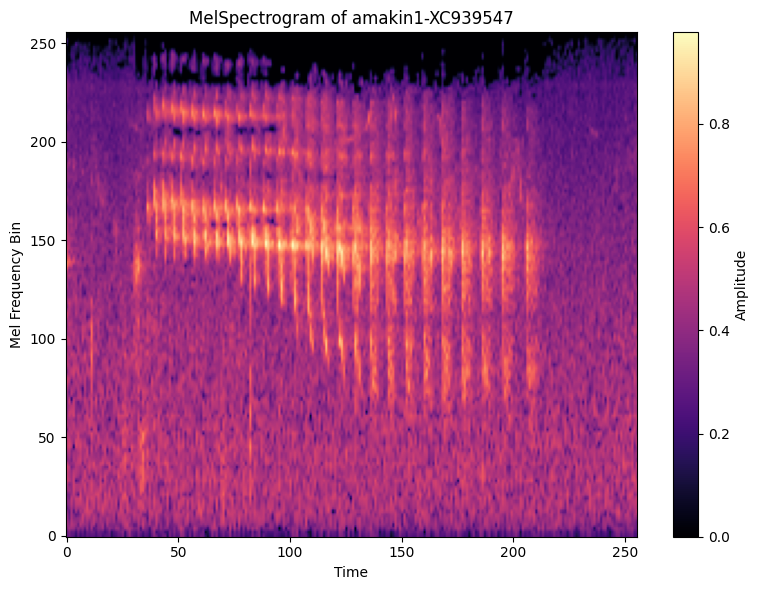

In [126]:
# 表示したい species_id を指定（例: 'pitangsp'）
samplename= df["samplename"].iloc[i] 
species_id = samplename # 実際のIDに置き換えてください

# Melスペクトログラムを取得
mel = spec[species_id]  # shape: (256, 256)

# 表示
plt.figure(figsize=(8, 6))
plt.imshow(mel, aspect='auto', origin='lower', cmap='magma')
plt.title(f"MelSpectrogram of {species_id}")
plt.xlabel("Time")
plt.ylabel("Mel Frequency Bin")
plt.colorbar(label='Amplitude')
plt.tight_layout()
plt.show()

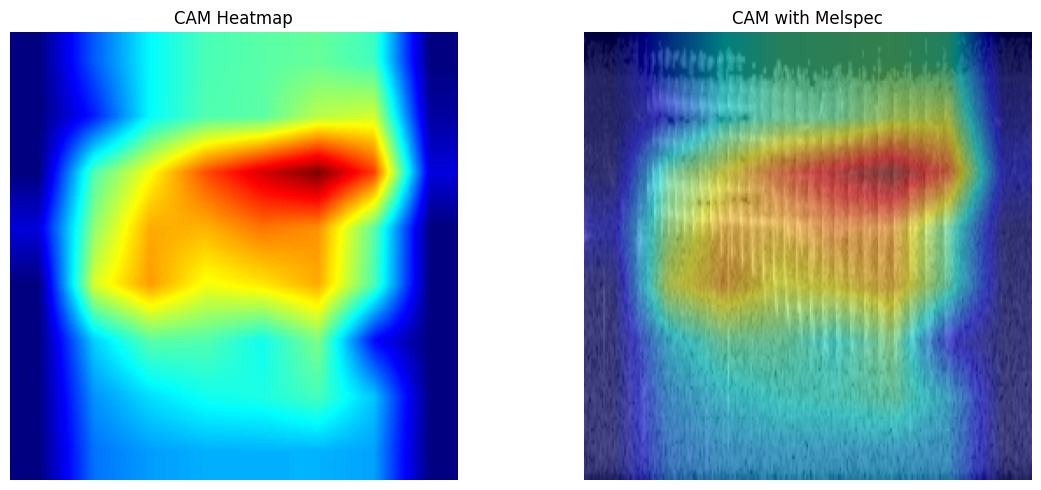

target_class: 60
samplename: amakin1-XC939547


In [127]:
mel = spec[samplename]  # Melスペクトログラム（NumPy形式）
model = models[0]  # あなたのモデル
target_class = df["target"].iloc[i]  # 例：注目するspeciesのclass index

show_gradcam(model, mel, target_class, title="CAM with Melspec")
print("target_class:", target_class)
print("samplename:", samplename)